In [1]:
import numpy as np
import pandas as pd
import helper
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import ParameterGrid

use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Load the data
papers = pd.read_csv('database_clean.csv')
embeddings_df = pd.read_csv("use_embeddings.csv")

# Drop the id feature
embeddings_df_clean = embeddings_df.drop(columns=["id"])

embeddings = embeddings_df_clean.values

# train 70%, val 20%, test 10%
X_train, X_temp = train_test_split(embeddings, test_size=0.3, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=1/3, random_state=42)

X_train_paper, X_temp_paper = train_test_split(papers, test_size=0.3, random_state=42)
X_val_paper, X_test_paper = train_test_split(X_temp_paper, test_size=1/3, random_state=42)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (7745, 512), Validation: (2213, 512), Test: (1107, 512)


In [2]:
print(embeddings_df)

              0         1         2         3         4         5         6  \
0     -0.038129 -0.062161 -0.019255 -0.038945 -0.046120 -0.036084 -0.054072   
1     -0.023383  0.010423 -0.053019 -0.051092 -0.047135 -0.039290 -0.001832   
2     -0.045943 -0.074961  0.041563 -0.065722 -0.051982  0.028680  0.032424   
3     -0.066666 -0.047887 -0.033960 -0.065404 -0.064759  0.035115 -0.035157   
4     -0.009217 -0.051146 -0.009144  0.017567  0.027823 -0.052760 -0.018785   
...         ...       ...       ...       ...       ...       ...       ...   
11060  0.057548  0.048706  0.044268 -0.034815 -0.058915 -0.044486 -0.023411   
11061  0.022761 -0.056335 -0.064894 -0.057125  0.008123 -0.064875  0.021718   
11062 -0.001666 -0.046085 -0.017972 -0.024489  0.054256 -0.045583 -0.058886   
11063  0.045317 -0.038207  0.026376 -0.022304  0.050158 -0.026467  0.033233   
11064 -0.058042 -0.062914  0.024296 -0.045535 -0.057408  0.030156 -0.005588   

              7         8         9  ...       503 

In [3]:
# Autoencoder builder used with Grid Search Algorithm
def build_autoencoder(input_dim, encoding_dim=64, activation="relu", learning_rate=0.0001, l2_reg=0.01):
    # Encoder - 1 hidden layer
    encoder = keras.Sequential([
        layers.InputLayer(input_shape=(input_dim,)),
        layers.Dense(encoding_dim, activation=activation, kernel_regularizer=regularizers.l2(l2_reg)),
    ])

    # Decoder
    decoder = keras.Sequential([
        layers.Dense(input_dim, activation="sigmoid")  
    ])

    # Connect Encoder & Decoder
    input_layer = layers.Input(shape=(input_dim,))
    encoded = encoder(input_layer)
    decoded = decoder(encoded)

    autoencoder = keras.Model(input_layer, decoded)

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    autoencoder.compile(optimizer=optimizer, loss="mse")

    return autoencoder, encoder, decoder

In [4]:
# Define the hyperparameter grid
param_grid = {
    "encoding_dim": [32, 64, 128],  # Number of neurons in the encoding layer
    "activation": ["relu"],  # Activation function
    "learning_rate": [0.01, 0.001],  # Learning rate for Adam optimizer
    "l2_reg": [0.01, 0.001]  # L2 regularization strength
}

# Generate all possible hyperparameter combinations
grid = list(ParameterGrid(param_grid))

In [5]:
best_loss = float("inf")
best_params = None
best_encoder = None
best_decoder = None
best_autoencoder = None
best_history = None

# Iterate through hyperparameter combinations
for params in grid:
    print(f"Testing params: {params}")
    
    # Build model with current hyperparameters
    autoencoder, encoder, decoder = build_autoencoder(X_train.shape[1], **params)
    
    # Train model
    history = autoencoder.fit(X_train, X_train, 
                              epochs=30, batch_size=32, 
                              validation_data=(X_val, X_val),
                              verbose=0)  # Use verbose=1 to see training progress

    # Get validation loss
    val_loss = min(history.history["val_loss"])
    
    # Check if this model is the best so far and save if it is
    if val_loss < best_loss:
        best_loss = val_loss
        best_params = params
        best_encoder = encoder
        best_decoder = decoder
        best_history = history
        best_autoencoder = autoencoder

print(f"\nBest Params: {best_params}")
print(f"Best Validation Loss: {best_loss}")

Testing params: {'activation': 'relu', 'encoding_dim': 32, 'l2_reg': 0.01, 'learning_rate': 0.01}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Testing params: {'activation': 'relu', 'encoding_dim': 32, 'l2_reg': 0.01, 'learning_rate': 0.001}
Testing params: {'activation': 'relu', 'encoding_dim': 32, 'l2_reg': 0.001, 'learning_rate': 0.01}
Testing params: {'activation': 'relu', 'encoding_dim': 32, 'l2_reg': 0.001, 'learning_rate': 0.001}
Testing params: {'activation': 'relu', 'encoding_dim': 64, 'l2_reg': 0.01, 'learning_rate': 0.01}
Testing params: {'activation': 'relu', 'encoding_dim': 64, 'l2_reg': 0.01, 'learning_rate': 0.001}
Testing params: {'activation': 'relu', 'encoding_dim': 64, 'l2_reg': 0.001, 'learning_rate': 0.01}
Testing params: {'activation': 'relu', 'encoding_dim': 64, 'l2_reg': 0.001, 'learning_rate': 0.001}
Testing params: {'activation': 'relu', 'encoding_dim': 128, 'l2_reg': 0.01, 'learning_rate': 0.01}
Testing params: {'activation': 'relu', 'encoding_dim': 128, 'l2_reg': 0.01, 'learning_rate': 0.001}
Testing params: {'activation': 'relu', 'encoding_dim': 128, 'l2_reg': 0.001, 'learning_rate': 0.01}
Testing

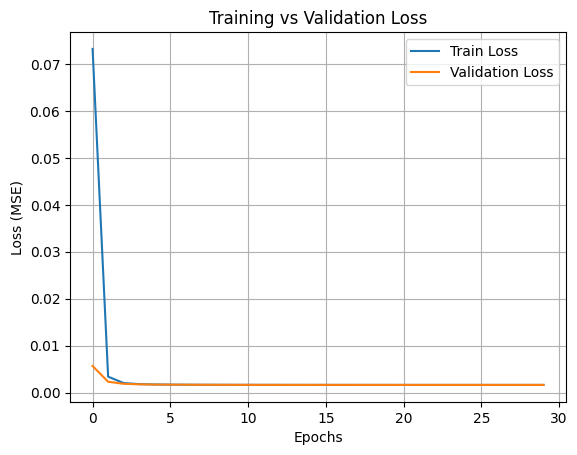

In [6]:
# Plot the Training and Validation Loss (MSE)
plt.plot(best_history.history["loss"], label="Train Loss")
plt.plot(best_history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.savefig("train.png", dpi=300, bbox_inches="tight")
plt.show()

In [7]:
# Evaluate how well the autoencoder model encodes
from sklearn.metrics import mean_squared_error

# Reconstruct the test set
reconstructed_test = best_autoencoder.predict(X_test)

# Evaluate how similar the reconstructed test set is with the actual test set
mse = mean_squared_error(X_test, reconstructed_test)

print(f"Mean Squared Error (MSE) on the test set: {mse:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Squared Error (MSE) on the test set: 0.0016


In [8]:
print(X_test.shape)

(1107, 512)


In [9]:
print(reconstructed_test.shape)

(1107, 512)


In [10]:
# Encode the train and test set using the autoencoder's encoder
encoded_train = best_encoder.predict(X_train)
encoded_test = best_encoder.predict(X_test)

# Calculate the similarity matrix for both the original and encoded versions
similarity_matrix = cosine_similarity(X_test, X_train)
similarity_matrix_encoded = cosine_similarity(encoded_test, encoded_train)

# Sort the similarity matrix in reverse order and select the top 10 data points
top_n = 10
top_indices = np.argsort(-similarity_matrix_encoded, axis=1)[:, :top_n]  

# Print and store the id of the recommended papers
recommended_paper_ids = []

for i, test_idx in enumerate(top_indices):
    recommended_for_test = []
    print(f"\nTest Paper {i+1}:")
    for j, train_idx in enumerate(test_idx):
        recommended_paper_id = papers.iloc[train_idx]["id"]
        recommended_for_test.append(recommended_paper_id)
        print(f"  {j+1}. Recommended Paper ID: {recommended_paper_id} (Encoded_Similarity: {similarity_matrix_encoded[i, train_idx]:.4f}) (Similarity: {similarity_matrix[i, train_idx]:.4f})")
    recommended_paper_ids.append(recommended_for_test)

# Sort the similarity matrix in reverse order and select the top 10 data points
top_n = 10
top_indices = np.argsort(-similarity_matrix, axis=1)[:, :top_n]  

# Print and store the id of the actual best papers
best_paper_ids = []

for i, test_idx in enumerate(top_indices):
    best_for_test = []
    print(f"\nTest Paper {i+1}:")
    for j, train_idx in enumerate(test_idx):
        best_paper_id = papers.iloc[train_idx]["id"]
        best_for_test.append(best_paper_id)
        print(f"  {j+1}. Unencoded Recommended Paper ID: {best_paper_id} (Similarity: {similarity_matrix[i, train_idx]:.4f}) (Encoded_Similarity: {similarity_matrix_encoded[i, train_idx]:.4f})")
    best_paper_ids.append(best_for_test)

243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Test Paper 1:
  1. Recommended Paper ID: 8927d913-0522-4199-9fc1-839fe4fc69a6 (Encoded_Similarity: 1.0000) (Similarity: 0.1677)
  2. Recommended Paper ID: 1e22202c-fb2f-48f6-86ff-eec003b5a31a (Encoded_Similarity: 1.0000) (Similarity: 0.0887)
  3. Recommended Paper ID: bb3348cd-d5cd-4d77-9901-5ac9cf7103b1 (Encoded_Similarity: 1.0000) (Similarity: 0.1899)
  4. Recommended Paper ID: 26581716-1dc1-4924-85e0-35f03cbcfe1f (Encoded_Similarity: 1.0000) (Similarity: 0.0944)
  5. Recommended Paper ID: 372b760d-60da-4ee3-ac84-f968d4c38213 (Encoded_Similarity: 1.0000) (Similarity: 0.2031)
  6. Recommended Paper ID: 84f97084-a070-498a-bb32-0b39353efe58 (Encoded_Similarity: 1.0000) (Similarity: 0.1868)
  7. Recommended Paper ID: c029061b-b610-4324-a25d-af87d02a5380 (Encoded_Similarity: 1.0000) (Similarity: 0.2496)
  8. Recommended Paper ID: 5dc3d673-79e4-4a22-b33a-7450fcaa3a9a (Encoded_Similarity: 1.0000) (Similarity

In [11]:
# Calculate the mean and median of the cosine similarity matrix values for each test papers
similarity_mean, similarity_median = helper.cosine_similarity_mean_median(similarity_matrix)
print(similarity_mean)
print(similarity_median)

[0.36683727 0.54388692 0.62615334 ... 0.54182528 0.69241493 0.62370943]
[0.3643092  0.5377832  0.61065728 ... 0.53506462 0.69268256 0.61628882]


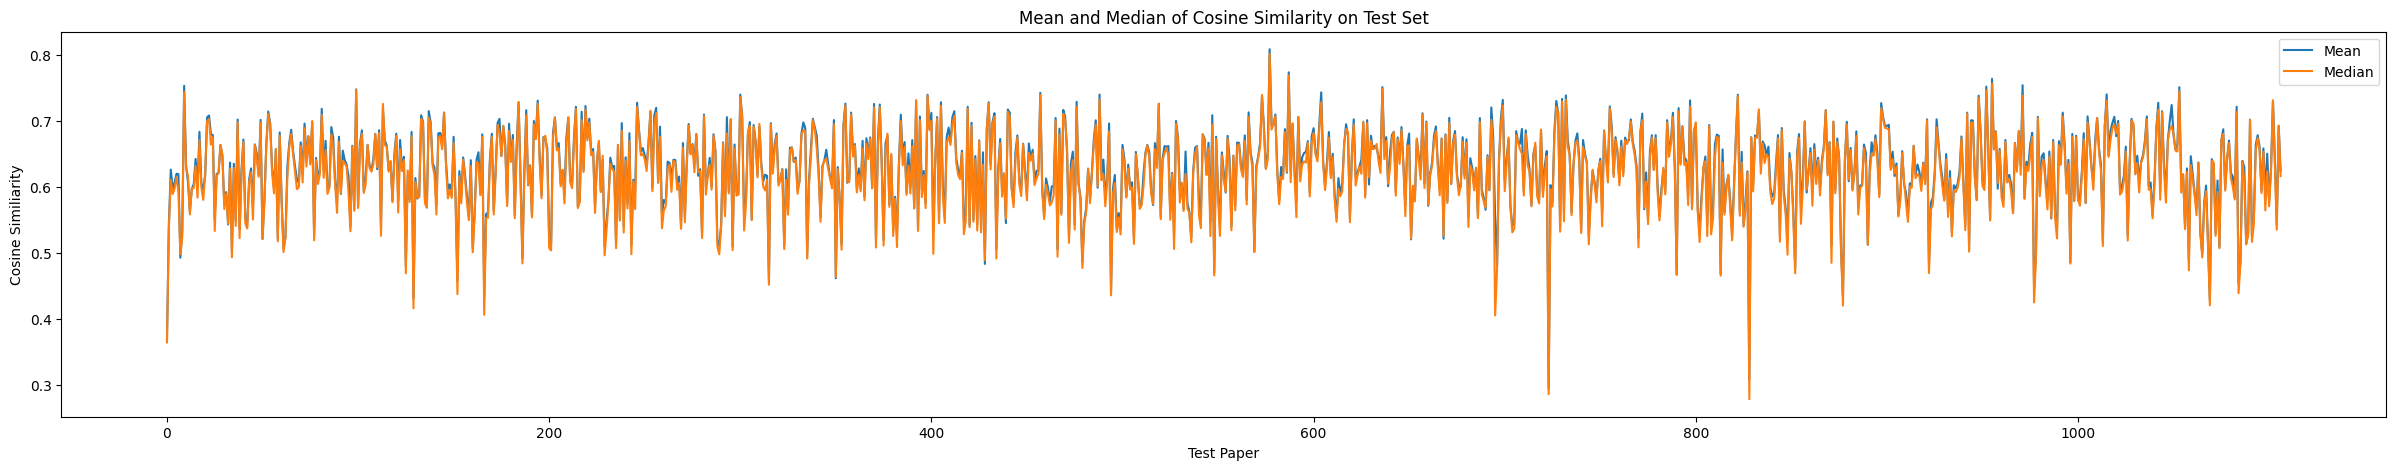

In [12]:
# Plot the mean and median of the cosine similarity matrix values for each test papers
helper.plot_cosine_similarity(similarity_mean, similarity_median)

In [13]:
# Get the embeddings for the top 10 papers for each test papers
emb_paper_id = embeddings_df["id"].tolist()
embeddings = embeddings_df.drop("id", axis=1).values.tolist()


top10_embeddings = []

np_recommended_paper_ids = np.array(recommended_paper_ids)

for top10_ids in np_recommended_paper_ids:
    top10_embedding = []
    for paper_id in top10_ids:
        top10_embedding.append(embeddings[emb_paper_id.index(paper_id)])
    top10_embeddings.append(top10_embedding)

top10_embeddings = np.array(top10_embeddings)
test_embeddings = np.array(X_test)

print(top10_embeddings.shape)
print(test_embeddings.shape)

(1107, 10, 512)
(1107, 512)


In [14]:
# Calculate the mean and median of Pearson Correlation Coefficient values for the embeddings
correlation_mean, correlation_median = helper.compute_pearson_correlation(test_embeddings, top10_embeddings)
print(correlation_mean)

[0.16424045521423336, 0.28907783058336817, 0.25961374254751635, 0.28093987528517117, 0.32381064411039107, 0.33292133061835416, 0.2566566790830937, 0.21045527910847853, 0.20912018842055913, 0.4285807751937492, 0.3240509886789782, 0.309938258198417, 0.26102915212895184, 0.32780073569357226, 0.2964078943864592, 0.34823002037788064, 0.39623777391125736, 0.4204596561250538, 0.26823696679733633, 0.2569634675030155, 0.38233350902525826, 0.37179088528888365, 0.34900774969762527, 0.29656717504850466, 0.4474791620580191, 0.3045925148468663, 0.36197110092904644, 0.3014607340328263, 0.44906742287559015, 0.3399925303878213, 0.3384493013053357, 0.3207511467170755, 0.229810769147229, 0.3478834657353453, 0.21465739558284339, 0.39518569320147534, 0.21515220599060206, 0.33688401041815197, 0.22343251101084136, 0.2988139357274804, 0.22203992012740695, 0.30732141631553805, 0.24913980146080092, 0.3847163076360329, 0.3136264287373358, 0.3034275585605531, 0.3886034011654217, 0.3616944134331895, 0.319961705571

In [15]:
print(correlation_median)

[0.16634661891106314, 0.28540103786008814, 0.24377404941648184, 0.2737450065253336, 0.3065443199894121, 0.3474540965128094, 0.24040508849555314, 0.2242391125376883, 0.2094311221737161, 0.41219234145734207, 0.32489208950334714, 0.29981235028661224, 0.2631509739427968, 0.29353453352664194, 0.27196646864611407, 0.34677082475256227, 0.3957854678181121, 0.4184783814523402, 0.2891020626902804, 0.2672851689214471, 0.3810112576918354, 0.4150891382831933, 0.3388654492621786, 0.3510619327466579, 0.43244073130860183, 0.3234805370565099, 0.35303737082942743, 0.27489640433328566, 0.441918944557934, 0.3298908472616082, 0.3458452465491114, 0.3114309802390841, 0.22981839293468573, 0.3329849179826303, 0.23460901804693396, 0.3683248553357604, 0.2191619527651234, 0.32954972509516833, 0.26001511664953403, 0.2918817979920315, 0.20835934144269197, 0.3029472429042649, 0.28744259178667825, 0.40790014594095253, 0.3062247531053701, 0.29213191297596464, 0.3994141269684638, 0.38757279379115883, 0.293713016099846,

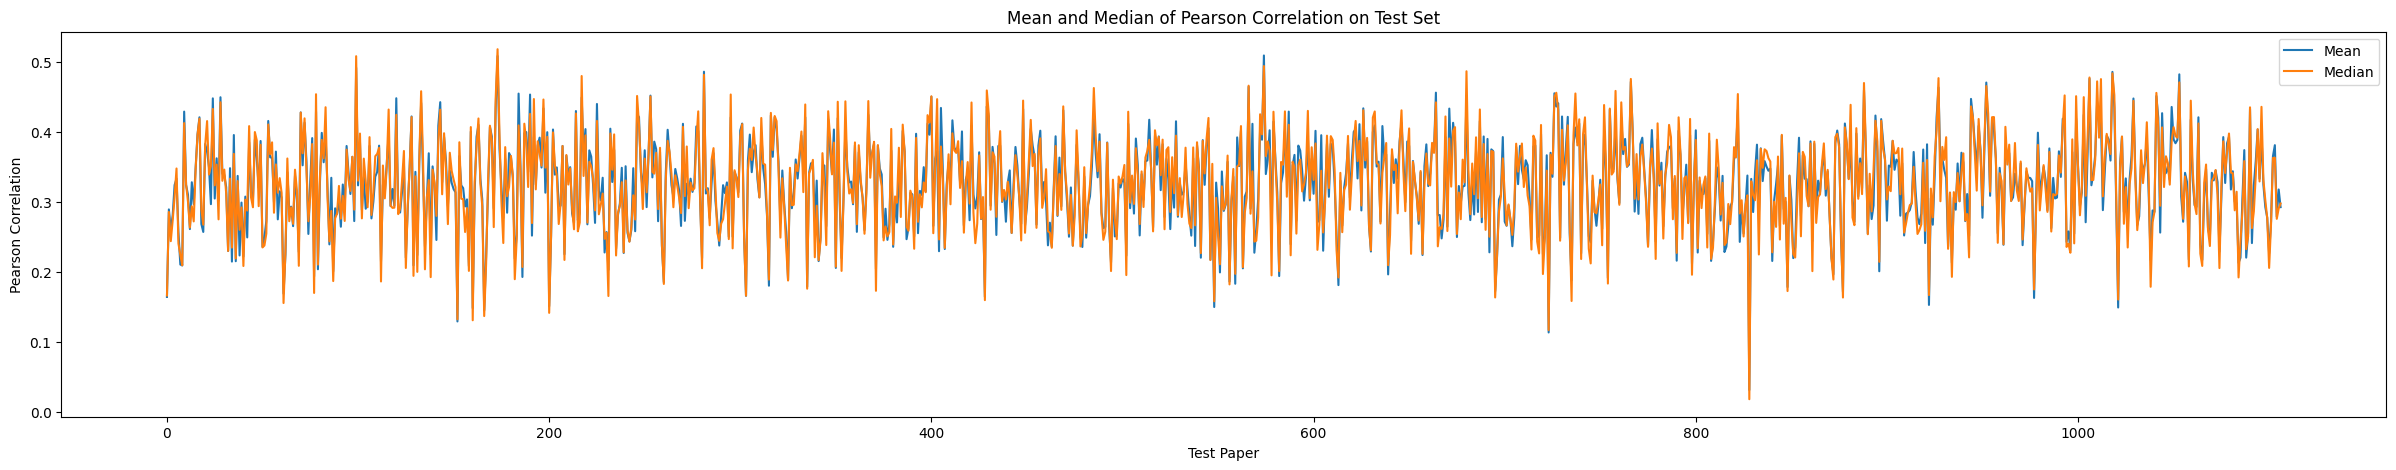

In [16]:
# Plot the mean and median of the Pearson Correlation Coefficient values for each test papers
helper.plot_pearson_correlation(correlation_mean, correlation_median)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
Input: stochastic hybrid system modeling
Recommended papers
0: Cardiac image registration by combining point set matching with surface structure features
1: Solving Set Optimization Problems by Cardinality Optimization via Weak Constraints with an Application to Argumentation.
2: Fast and simple text replacement algorithm for text-based augmented reality
3: Using Change-Sets to Achieve a Bounded Undo and Make Tutorials in 3D Version Control Systems
4: The feature selection algorithm based on feature overlapping and group overlapping
5: Time-Tradeoff Sequences for Analyzing Discounting and Time Inconsistency
6: Simulation-Based Sailboat Trajectory Optimization using On-Board Heterogeneous Computers
7: A self-tuning velocity observer formulation for a class of nonlinear systems
8: A Composite Recommendation System for Planning Tourist Visits
9: A NoSQL–SQL Hybrid Organization and Management Approach for Real

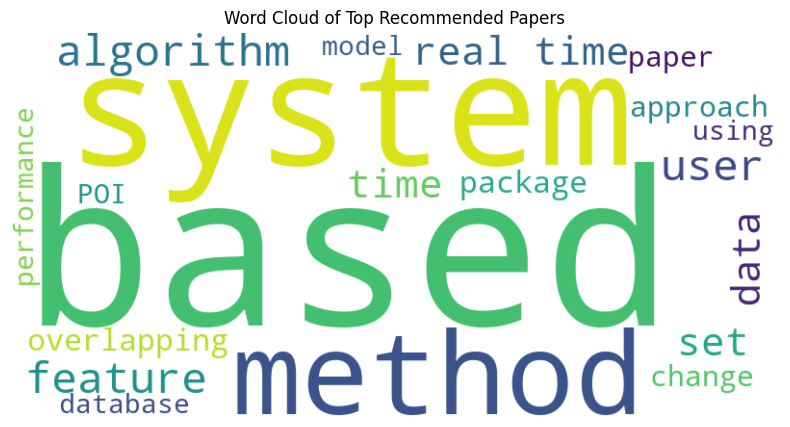

In [17]:
# Input string
input_query = "stochastic hybrid system modeling"

# Turn the input string into numerical vector using Universal Sentence Encoder (USE)
input_vector = use_model([input_query]).numpy()

embeddings = embeddings_df_clean.values

# Encode using Autoencoder's encoding layer the input vector and the embeddings (numerical vectors of the entire dataset)
encoded_vector = best_autoencoder.predict(input_vector)
encoded_dataset = best_autoencoder.predict(embeddings)

# Calcualte Cosine Similarity matrix using both the encoded and non encoded vectors.
similarity_matrix = cosine_similarity(input_vector, embeddings)
similarity_matrix_encoded = cosine_similarity(encoded_vector, encoded_dataset)

# Sort the similarity matrix in reverse order and select the top 10 data points
top_n = 10
top_indices = np.argsort(-similarity_matrix_encoded, axis=1)[:, :top_n]  

# Print and store the id, title and abstract of the recommended papers
paper_ids = []
paper_texts = []
top10_embeddings = []
print("Input: stochastic hybrid system modeling")
print("Recommended papers")
for i, paper_idx in enumerate(top_indices[0]):
    paper_info = papers.iloc[paper_idx]
    paper_ids.append(paper_info["id"])
    paper_texts.append(paper_info["title"] + " " + paper_info["abstract"])
    top10_embeddings.append(embeddings[paper_idx])
    print(f"{i}: {paper_info["title"]}")

# Create a word cloud of common words found in the recommended papers
helper.createWCloud(paper_ids, papers)

In [18]:
# Calculate mean and median of cosine similarity values
similarity_mean, similarity_median = helper.cosine_similarity_mean_median(similarity_matrix)
print(similarity_mean)
print(similarity_median)

[0.47802607]
[0.47268817]


In [19]:
# Calculate mean and median of Pearson Correlation Coefficient values
top10_embeddings = np.array([top10_embeddings])
print(input_vector.shape)
print(top10_embeddings.shape)
correlation_mean, correlation_median = helper.compute_pearson_correlation(input_vector, top10_embeddings)
print(correlation_mean)
print(correlation_median)

(1, 512)
(1, 10, 512)
[0.23524164096946204]
[0.24069774549285988]


In [21]:
# Save the model
autoencoder.save('autoencoder_model.keras')